
# 🏋️ Build a dataloader

In this notebook, we will show you how to work with parquet files, and load data in chunks. Then, we'll create a dataloader for our future ML models.




# Set up

In [10]:
# get workshop code
import os
import sys
IN_COLAB = os.getenv("COLAB_RELEASE_TAG")
if IN_COLAB:
    !git clone https://github.com/cottascience/crosstalk-q1-2025
    sys.path.append('./crosstalk-q1-2025')
else:
    sys.path.append('..')

fatal: destination path 'crosstalk-q1-2025' already exists and is not an empty directory.


We've prepared a training dataset for you which will download when you run the next cell.

In [11]:
# Download the file from google drive
import gdown
import os

file_ids = {'test' : '19oR_A2UNUvy7pyL3J11oixkmF1m-bZBl',
            'train':'11S5p0QgP1X9rOFiIjNSLydLenJwm7hle'}

for name, file_id in file_ids.items():
    filename = f'crosstalk_{name}.parquet'
    if not os.path.exists(filename):
        gdown.download(id=file_id, output=filename, quiet=False)

Our data is saved in a [parquet file](https://en.wikipedia.org/wiki/Apache_Parquet). This is somewhat similar to a spreadsheet: each feature is in a column and each row describes one mollecule in out dataset. The parquet format is important for our purposes because it can store a lot of data - we have >300k molecules - and it can be read efficiently (don't try opening this in excel!).

Parquet is described as column-oriented, meaning that it's optimized for loading a single feature for all rows, but not for loading all features at the same time. That is: it's easy to get all the data for one column.

In [12]:
# package to efficiently read in data from parquet file
from pyarrow.parquet import ParquetFile
import pyarrow as pa

# packages to help us with data manipulation in tables
import pandas as pd
import numpy as np
import scipy

This is a large file, so we won't load the whole thing into memory all at once. Parquet has some nice utilities for telling us some info about the dataset, without having to actually load it.



In [13]:
# Get parquet file
pf = ParquetFile('crosstalk_train.parquet')

In [5]:
# How many rows and columns?
print(pf.metadata)

  created_by: parquet-cpp-arrow version 17.0.0
  num_columns: 16
  num_rows: 375595
  num_row_groups: 1
  format_version: 2.6
  serialized_size: 53693


In [6]:
# What are the column names?
print(pf.schema.names)

['ID', 'DEL_ID', 'DELLabel', 'RawCount', 'Target', 'ECFP4', 'ECFP6', 'FCFP4', 'FCFP6', 'MACCS', 'RDK', 'AVALON', 'ATOMPAIR', 'TOPTOR', 'MW', 'ALOGP']


Take some time to explore what the different columns mean. For more info see the [aircheck readme](https://aircheck.ai/readme).


| Field Name   | Data Type | Mode     | Description                                                                 |
|--------------|-----------|----------|-----------------------------------------------------------------------------|
| ID           | Long      | Required | Unique computed ID from DEL_ID concatenating DEL Library ID and Building Block IDs. |
| DEL_ID       | String    | Required | Unique ID of full enumerated DNA-Encoded Library (DEL) compound.            |
| DELLabel        | Integer   | Required | Binary classification label for observed enrichment (0 not enriched, 1 enriched). |
| RawCount     | Integer   | Nullable | The sequence count (enrichment) for the specific target.                    |
| TARGET_ID    | String    | Required | Unique ID of the target.                                                   |
| ECFP4        | Bytes     | Nullable | Count (non-binary) fingerprint generated using Extended Connectivity Fingerprint (ECFP) with radius 2 and 2048 bits. |
| ECFP6        | Bytes     | Nullable | Count (non-binary) fingerprint generated using Extended Connectivity Fingerprint (ECFP) with radius 3 and 2048 bits. |
| FCFP4        | Bytes     | Nullable | Count (non-binary) fingerprint generated using Functional Connectivity Fingerprints (FCFP) with radius 2 and 2048 bits. |
| FCFP6        | Bytes     | Nullable | Count (non-binary) fingerprint generated using Functional Connectivity Fingerprints (FCFP) with radius 3 and 2048 bits. |
| MACCS        | Bytes     | Nullable | FP generated using the Molecular Access System (MACCS).                     |
| RDK          | Bytes     | Nullable | FP generated using the RDKit fingerprint.                                  |
| AVALON       | Bytes     | Nullable | FP generated using the Avalon fingerprint.                                 |
| ATOMPAIR     | Bytes     | Nullable | FP generated using the Atom Pair fingerprint.                               |
| TOPTOR       | Bytes     | Nullable | FP generated using the Topological Torsion fingerprint.                     |
| MW           | Float     | Nullable | Molecular weight of the enumerated DEL rounded to its integer value.        |
| ALOGP        | Float     | Nullable | Calculated LogP of the enumerated DEL rounded to one decimal. Synonymous with ClogP. |




 Let's look at just the first 10 rows. We added a timer here to get an understanding of the efficiency.

In [7]:
%%time

# load all columns of the first 10 rows
rows_to_load = next(pf.iter_batches(batch_size = 10))
first_ten_rows = pa.Table.from_batches([rows_to_load]).to_pandas()

CPU times: user 157 ms, sys: 2.1 s, total: 2.26 s
Wall time: 3.87 s


## Take a peek 👀

In [8]:
display(first_ten_rows)

,ID,DEL_ID,DELLabel,RawCount,Target,ECFP4,ECFP6,FCFP4,FCFP6,MACCS,RDK,AVALON,ATOMPAIR,TOPTOR,MW,ALOGP
0,22010204180211,L22-102-418-211,0,0,WDR91,"0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...","0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...","12,1,2,0,18,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...","12,1,2,0,18,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...","0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...","1,1,1,0,1,1,0,0,1,0,1,1,0,1,1,1,0,0,1,1,0,0,1,...","0,0,0,1,2,0,0,0,0,0,0,0,0,0,0,15,0,3,0,0,0,0,0...","1,0,0,0,3,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,...","0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...",493,3.4
1,30023100530730,L30-231-53-730,0,0,WDR91,"0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...","0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...","12,2,6,0,14,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...","12,2,6,0,14,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...","0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...","1,1,0,1,1,1,1,1,0,1,1,1,0,1,0,1,1,1,0,1,0,1,1,...","0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,22,0,0,0,0,0,1,2...","0,0,0,0,2,1,0,0,0,0,0,6,0,0,0,0,0,0,0,0,0,0,0,...","0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...",494,3.4
2,30004703160748,L30-47-316-748,0,0,WDR91,"0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...","0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...","10,1,2,0,16,0,4,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,...","10,1,2,0,16,0,4,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,...","0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...","1,1,1,1,0,1,1,1,1,1,1,1,0,1,1,0,1,0,0,1,0,0,0,...","1,0,0,1,4,0,1,0,0,0,0,0,0,0,0,14,0,0,0,0,0,0,0...","0,0,0,0,1,0,0,1,0,0,0,2,0,0,0,0,0,0,0,0,0,0,3,...","0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...",494,3.4
3,30004200250347,L30-42-25-347,0,0,WDR91,"0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...","0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...","12,2,3,0,14,0,3,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,...","12,2,3,0,14,0,3,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,...","0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...","1,0,0,0,0,1,0,1,0,0,0,1,0,0,1,1,1,0,1,0,0,0,0,...","0,0,0,0,4,0,0,0,0,0,0,0,0,0,1,11,0,0,0,0,0,0,0...","0,1,0,1,3,0,0,1,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,...","0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...",494,3.4
4,22002800290407,L22-28-29-407,0,0,WDR91,"0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...","0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...","8,2,3,0,17,1,2,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0...","8,2,3,0,17,1,2,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0...","0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...","1,1,0,1,1,1,1,1,1,1,1,1,0,0,1,0,1,1,0,1,0,1,0,...","1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,9,0,0,0,0,0,0,0,...","0,1,0,0,4,0,0,0,0,0,0,5,4,0,0,0,0,0,0,0,0,0,0,...","0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...",495,3.4
5,48060602780359,L48-606-278-359,0,0,WDR91,"0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...","0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...","10,3,3,0,18,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...","10,3,4,0,18,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...","0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,...","1,1,0,0,1,1,0,1,0,0,1,1,0,0,0,0,1,0,1,1,1,0,0,...","0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8,0,0,0,0,0,0,0,...","0,1,1,0,6,2,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,...","0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...",498,3.4
6,44039000280877,L44-390-28-877,0,0,WDR91,"0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...","0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...","13,1,4,0,12,0,0,0,3,0,0,0,0,0,0,0,0,0,0,1,0,0,...","13,1,4,0,12,0,0,0,3,0,0,0,0,0,0,0,0,0,0,1,0,0,...","0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...","1,1,1,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,...","0,0,0,0,8,0,0,0,0,0,0,0,0,0,0,3,0,2,0,0,0,0,0,...","0,0,0,0,2,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,...","0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...",498,3.4
7,22010205280358,L22-102-528-358,1,7,WDR91,"0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...","0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...","12,1,3,0,17,0,3,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...","12,1,3,1,17,0,3,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...","0,0,0,0,0,0,0,0,0,0,

It took about 2 seconds to load all columns for 10 rows. But remember, this is not what parquet is optimized for.

How long will it take to load all rows for 1 column?

In [9]:
%%time

# load all rows of the label column
lots_of_rows = pf.read(columns = ['DELLabel']).to_pandas()

CPU times: user 5.96 ms, sys: 0 ns, total: 5.96 ms
Wall time: 10.8 ms


In [10]:
lots_of_rows = pf.read(columns = ['DELLabel']).to_pandas()
print(lots_of_rows.shape)

(375595, 1)


Only ~5 miliseconds for more than 375,000 rows! What a difference!

This happens partly because of the *type* of the column we loaded. The `DELLabel` is an integer: 0 or 1 (see columns description above)

It can be slower to load a different column type. Because parquet is column-oriented, loading each column independently is possible. This is what makes it fast to load lots of rows for only the `DELLabel` column. There are slower columns which require more memory, for example the fingerprints:

In [11]:
%%time

# load all rows of the fingerprint column
df = pf.read(columns = ['ECFP6']).to_pandas()

CPU times: user 3.71 s, sys: 3.93 s, total: 7.64 s
Wall time: 10.2 s


When we loaded the first 10 rows, we load all columns, including the slow ones. Let's check the size of this data frame which only has a ECFP6 column:


In [12]:
from pympler import asizeof

# define a little function to print the size of an object in memory
def check_size(obj):
  obj_size_bytes = asizeof.asizeof(obj)
  obj_size_gb = obj_size_bytes / 1024 ** 3
  print(f"Object size: {obj_size_gb:.3f} GB")

In [13]:
check_size(df)

Object size: 2.905 GB


We have 11 fingerprints to read, and if each column is ~2GB in size, we'd need about 20GB of RAM to load it all at once. Collab only gives us 12GB 😥 - let's have a look at some strategies for how we can handle this.

# 🐏 Can't fit the whole dataset into RAM

Our data is too big to load in all columns and all rows at once. If you try, colab will crash and look like this:

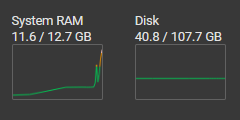

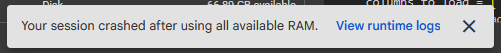

Keep an eye on your system RAM as you go through this notebook.

## Why is it so big?
Each mollecular finger print is actually a long string of data. In some ways, we don't have just 11 features, but rather tens of thousands!

In [14]:
first_ten_rows.iloc[0]

,0
ID,22010204180211
DEL_ID,L22-102-418-211
DELLabel,0
RawCount,0
Target,WDR91
ECFP4,"0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,..."
ECFP6,"0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,..."
FCFP4,"12,1,2,0,18,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,..."
FCFP6,"12,1,2,0,18,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,..."
MACCS,"0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,..."


In [15]:
fps =  ['ECFP4', 'ECFP6', 'FCFP4', 'FCFP6', 'MACCS', 'RDK', 'AVALON', 'ATOMPAIR', 'TOPTOR']
[len(first_ten_rows[f][9]) for f in fps]

[4095, 4095, 4097, 4097, 333, 4095, 4130, 4098, 4095]

## How can we be memory efficient?

We need to be careful when loading in data, and we can also think about clever ways to store it once it's in memory.

### 1. Don't load everything at once

We saw a simple example of memory conservation already: just don't load too much data at once! We did this in two ways:

* Load only 10 rows, all columns
* Load only 1 column, all rows


Loading a smaller subset of the data is a good way to get started on training and debugging.


In [16]:
rows_to_load = next(pf.iter_batches(columns = ['ECFP6'], batch_size = 50000))
df = pa.Table.from_batches([rows_to_load]).to_pandas()

In [17]:
df

,ECFP6
0,"0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,..."
1,"0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,..."
2,"0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,..."
3,"0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,..."
4,"0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,..."
...,...
49995,"0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,..."
49996,"0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,..."
49997,"0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,..."
49998,"0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,..."


In [18]:
check_size(df)

Object size: 0.387 GB


### 2. Use sparce matrices
We can also make use of sparse matrices to help with this: this is a type of matrix  which only keeps track of non-zero entries. First we have to split tis long fingerprint from a comma separated string into lots of columns. Notice it takes up a lot more space like this!

In [19]:
ECFP6_exploded = df['ECFP6'].str.split(',', expand=True).astype(int, copy=False)

In [20]:
ECFP6_exploded

,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,0,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
49996,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
49997,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
49998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [21]:
check_size(ECFP6_exploded)

Object size: 1.530 GB


Once we stop counting all the 0's, this fingerprint data is actually pretty small!

In [22]:
from scipy.sparse import csr_matrix

ECFP6_mat = csr_matrix(ECFP6_exploded)
ECFP6_mat

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 4491742 stored elements and shape (50000, 2048)>

In [23]:
check_size(ECFP6_mat)

Object size: 0.101 GB


## 3. Clean as you go

You can free up memory by deleting uneeded objects. Take a look at your RAM usage before and after running the next cell.

In [24]:
del df, ECFP6_mat, ECFP6_exploded, lots_of_rows, rows_to_load

## 4. Chunking

Chunking is one way we can get around loading everything at once. Since we know we want to turn this fingerprint into a sparse matrix, we can load in "chunks" of rows 10,000 at a time, then squish these chunks into sparse matrices and concetenate them together.

⚠️ This cell takes a long time to run so we cut it off early for demo purposes. If you use it in your own code be sure to remove this break statement

In [25]:
%%time
fp = 'ECFP6'

mats = []
for i, batch in enumerate(pf.iter_batches(batch_size=10000), 1):
    batch_df = batch.to_pandas()
    exploded = batch_df[fp].str.split(',', expand=True).astype(int, copy=False)
    sparse = csr_matrix(exploded)
    mats.append(sparse)
    print(f"Batch {i} done")
    del batch_df, exploded  # explicitly free memory
    if i == 10: break # exit early for notebook demo


sparse_fp = scipy.sparse.vstack(mats)

Batch 1 done
Batch 2 done
Batch 3 done
Batch 4 done
Batch 5 done
Batch 6 done
Batch 7 done
Batch 8 done
Batch 9 done
Batch 10 done
CPU times: user 1min 21s, sys: 12.2 s, total: 1min 33s
Wall time: 1min 34s


In [45]:
sparse_fp = scipy.sparse.vstack(mats)

In [47]:
check_size(sparse_fp)

Object size: 0.201 GB


Sparse matrix has 100k rows and is smaller (0.2GB) than the exploded 50k rows (1.5GB).

This makes it easier to work with, very demure & mindful

# Summary

Key takeaways:
1. Don't load everything at once
2. Use chunking to discard intermediate data where possible
3. Find strategies to make things smaller


🧠 This is an important engineering choice you will need to make: which fingerprints will you use, and how will you use them?

You might consider other ways of shrinking down the memory footprint of your data. This is also related to a challenge we will see in a future notebook: feature selection. Most likely, not all your data is useful. You will have to try out different subsets of data, and different feature normalization schemes.

# A basic dataloader

In machine learning frameworks (like PyTorch or TensorFlow), a Dataloader is an object/class that:
Takes a dataset (often already loaded into memory or accessible via an index).
Provides an iterable interface to yield batches of data (features and labels) for training or evaluation.
Handles shuffling, batching, and sometimes parallel loading or augmentation.

A Dataloader is a batching and iteration utility: It takes data (often already loaded, e.g., via load_x/load_y) and serves it up in batches for model training.

We'll show how to load data for one column, but you can customize this to load multiple columns, or your own pre-processed data if you choose to do some special transformations to the features prior to training.


Let's see this data loader in action, with a minimal classifier example

In [80]:
def basic_dataloader(filepath, x_col, y_col = None, n_to_load = None):
    """
    Loads data from a Parquet file into memory, optionally loading a subset of rows.

    Args:
        filepath (str): Path to the Parquet file.
        x_col (str): Name of the feature column.
        y_col (str, optional): Name of the label column. If None, only features are loaded. Defaults to None.
        n_to_load (int, optional): Number of rows to load. If None, loads all rows. Defaults to None.

    Returns:
        X (np.ndarray): Feature matrix of shape (n_samples, n_features).
        y (np.ndarray or None): Label array of shape (n_samples,) if y_col is provided, else None.
    """
    pf = pa.parquet.ParquetFile(filepath)
    columns = [x_col] + ([y_col] if y_col is not None else [])
    # load top n
    if n_to_load is not None:
      rows_to_load = next(pf.iter_batches(columns = columns, batch_size = n_to_load))
      df = pa.Table.from_batches([rows_to_load]).to_pandas()
    else:
      df = pf.read(columns = columns).to_pandas()

    # split X strings
    X = df[x_col].str.split(',', expand=True).astype(float, copy=False).values
    y = df[y_col].values if y_col is not None else None

    return X, y


In [77]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.model_selection import train_test_split

In [106]:
X, y = basic_dataloader("crosstalk_train.parquet", x_col="ECFP6", y_col = 'DELLabel', n_to_load = 10000)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [107]:
%%time
# Train model
model = SGDClassifier(loss="log_loss")
model.fit(X_train, y_train)

CPU times: user 5.57 s, sys: 25.4 ms, total: 5.59 s
Wall time: 5.28 s


SGDClassifier(loss='log_loss')

In [108]:
# Evaluate
yp = model.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, yp)
auprc = average_precision_score(y_test, yp)
print(f"AUROC: {auc:.4f}")
print(f"AUPRC: {auprc:.4f}")

AUROC: 0.8853
AUPRC: 0.5257


## 🧐 Advanced usage: Incremental learning with batches

Now we'll write another version of the data loader which will take each batch by iterating through the parquet file. Note: this only works for models which support incremental learning, which not all do.

We also take care of train/test split *inside* the dataloader in this case, because we are loading it incrementally.



In [105]:
def parquet_split_dataloader(filename, x_col, y_col=None, batch_size=1000, test_size=0.2, random_state=42, max_batches=None):
    """
    Loads data from a Parquet file in batches, splits each batch into train/test using sklearn's train_test_split,
    and optionally collects all test data. Allows stopping after a specified number of batches.

    Args:
        filename (str): Path to the Parquet file.
        x_col (str): Name of the feature column.
        y_col (str, optional): Name of the label column. Defaults to None.
        batch_size (int, optional): Number of rows per batch. Defaults to 1000.
        test_size (float, optional): Proportion of test data. Defaults to 0.2.
        random_state (int, optional): Random seed. Defaults to 42.
        max_batches (int, optional): Maximum number of batches to process. Defaults to None (all batches).
    Yields:
        (X_train, y_train), (X_test, y_test): Train and test splits for each batch.
    """
    pf = pa.parquet.ParquetFile(filename)
    columns = [x_col] + ([y_col] if y_col is not None else [])
    batch_iter = pf.iter_batches(columns=columns, batch_size=batch_size)
    test_X_list, test_y_list = [], []
    for i, batch in enumerate(batch_iter):
        if max_batches is not None and i >= max_batches:
            break
        df = pa.Table.from_batches([batch]).to_pandas()
        X = df[x_col].str.split(',', expand=True).astype(float, copy=False).values
        y = df[y_col].values if y_col is not None else None
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
        yield (X_train, y_train), (X_test, y_test)


⚠️ This cell takes a long time to run so we cut it off early for demo purposes. If you use it in your own code be sure to increase the `max_batches` in order to see all the data

In [109]:
%%time
# Train incrementally on the full file, batch by batch
model = SGDClassifier(loss="log_loss")
first = True

test_X_list = []
test_y_list = []
for (X_train, y_train), (X_test, y_test) in parquet_split_dataloader("crosstalk_train.parquet", "ECFP6", "DELLabel", batch_size=10000, max_batches=5):
    if first:
        model.partial_fit(X_train, y_train, classes=[0, 1])
        first = False
    else:
        model.partial_fit(X_train, y_train)
    test_X_list.append(X_test)
    test_y_list.append(y_test)

CPU times: user 38.7 s, sys: 780 ms, total: 39.5 s
Wall time: 39.8 s


In [110]:
  # Evaluate
  yp = model.predict_proba(X_test)[:, 1]
  auc = roc_auc_score(y_test, yp)
  auprc = average_precision_score(y_test, yp)
  print(f"AUROC: {auc:.4f}")
  print(f"AUPRC: {auprc:.4f}")

AUROC: 0.8871
AUPRC: 0.5620
